# Estimate fossil fuel sensitivity

Use a Monte Carlo method to model the fossil fuel uncertainty

In [11]:
import os, glob
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta

from acrg.obs import get_obs
from acrg.name.name import open_ds

import apo_emiss_func, apo_funcs, apo_plot_info

In [17]:
year = 2014
months = [8, 12]
site = 'WAO'
sigma = 3

start_dates = {month: datetime(year, month, 1) for month in months}
end_dates = {month: start_date + relativedelta(months=1, seconds=-1) for month, start_date in start_dates.items()}
date_strs = {month: f'{year}{str(month).zfill(2)}' for month in months}

oxidative_ratio_bio = 1.07
ff_uncertainty = 10     # per cent
number = 1e3

ocean_o2_model = 'nemo'

fontsize = 16

## Model APO
### Import the timeseries data

In [3]:
ts_data = apo_funcs.get_timeseries(sites = [site],
                                   sources = ['bc', 'ff', 'ocean',],
                                   year = year)
ts_data = {month: ts_data[site].sel(time=slice(start, end_dates[month]))
           for month, start in start_dates.items()}

Finding timeseries for WAO
bc: ['/user/work/vf20487/Timeseries/o2_co2/WAO_bc_timeseries_2014.nc']
ff: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ff_timeseries_2014.nc']
ocean: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_2014.nc']

Data variables:
['co2_ff', 'apo_bc', 'co2_bc', 'o2_bc', 'o2_ff', 'o2_ocean_nemo', 'n2_ocean_nemo', 'o2_ocean_ecco', 'o2_ocean_jena', 'co2_ocean_nemo']


### Model the APO

In [4]:
apo_model = {month: apo_emiss_func.apo(ocean_o2 = ts_month[f'o2_ocean_{ocean_o2_model}'],
                                       ff_co2 = ts_month.co2_ff,
                                       ocean_co2 = ts_month.co2_ocean_nemo,
                                       ocean_n2 = ts_month.n2_ocean_nemo,
                                       ff_o2 = ts_month.o2_ff,
                                       oxidative_ratio_bio = oxidative_ratio_bio,
                                       convert = False) + ts_month.apo_bc
             for month, ts_month in ts_data.items()}

### Import the obs data

In [5]:
apo_obs = {month: get_obs(['WAO'], 'apo', start, end_dates[month], keep_missing=True)['WAO'][0].mf
           for month, start in start_dates.items()}

Assuming status flag = 0 for all sites
Getting apo data for WAO...
... changing species from apo to APO
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20211221.nc
... slicing from 2014-08-01 00:00:00 to 2014-08-31 23:59:58.999999999
Assuming status flag = 0 for all sites
Getting apo data for WAO...
... changing species from apo to APO
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20211221.nc
... slicing from 2014-12-01 00:00:00 to 2014-12-31 23:59:58.999999999


## Run the Monte Carlo

### Create a random array of uncertainties to apply to the flux estimates

In [6]:
unc_array = np.random.normal(loc = 0,
                             scale = ff_uncertainty * 1e-2,
                             size = int(number))

In [10]:
apo_test = {month: np.zeros((int(number), int(len(ts_month.time))))
            for month, ts_month in ts_data.items()}
apo_diff = {month: np.zeros_like(apo_month) for month, apo_month in apo_test.items()}

for month, ts_month in ts_data.items():
    for uu, unc in enumerate(unc_array):
        apo_test[month][uu,:] = apo_emiss_func.apo(ff_co2 = ts_month.co2_ff * unc,
                                                   ocean_co2 = ts_month.co2_ocean_nemo,
                                                   ocean_o2 = ts_month[f'o2_ocean_{ocean_o2_model}'],
                                                   ocean_n2 = ts_month.n2_ocean_nemo,
                                                   ff_o2 = ts_month.o2_ff * unc,
                                                   oxidative_ratio_bio = oxidative_ratio_bio,
                                                   convert = False)
        apo_diff[month][uu,:] = apo_model[month] - apo_test[month][uu]

## See what it looks like

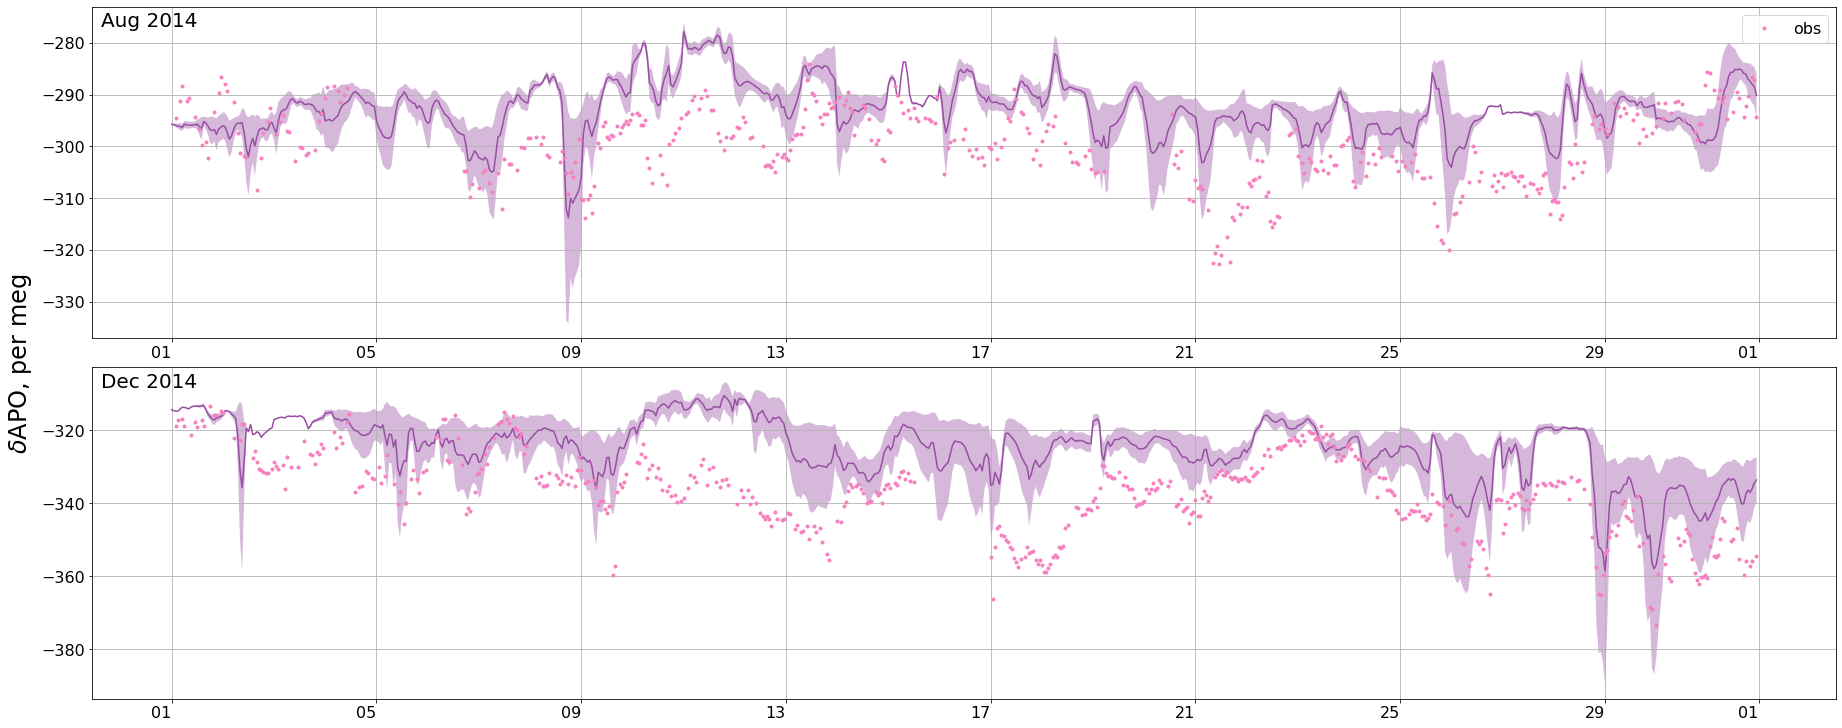

In [16]:
apo_uncertainty = {month: xr.DataArray(data = apo_test[month].std(axis=0),
                                       coords = {'time': ts_month.time},
                                       dims = ['time'])
                   for month, ts_month in ts_data.items()}

apo_uncertainty_sigma = {month: sigma * apo_month for month, apo_month in apo_uncertainty.items()}

fig, axes = plt.subplots(nrows=len(months), ncols=1, figsize=(25, 5*len(months)), constrained_layout=True)

for mm, (month, apo_month) in enumerate(apo_model.items()):
    unc_plot = axes[mm].fill_between(apo_month.time,
                                     apo_month - apo_uncertainty_sigma[month],
                                     apo_month + apo_uncertainty_sigma[month],
                                     facecolor=apo_plot_info.colors[ocean_o2_model],
                                     alpha=0.4)
    apo_plot = apo_month.plot(ax=axes[mm], color=apo_plot_info.colors[ocean_o2_model])

    obs_plot = apo_obs[month].plot(ax=axes[mm], color=apo_plot_info.colors['obs'],
                                   label='obs', marker='.', ls='none')

if len(months)>1:
       myFmt = mdates.DateFormatter('%d')
       [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
       ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
       text = [axes[mm].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[mm].transAxes, va='top', fontsize=20)
               for mm, month in enumerate(months)]
else:
       ticks = [ax.tick_params(labelsize=20) for ax in axes]

grid = [ax.grid() for ax in axes]
legend = axes[0].legend(loc='best', fontsize=fontsize)
xlab = [ax.set_xlabel('') for ax in axes]
ylab = [ax.set_ylabel('', fontsize=fontsize+2) for ax in axes]          # remove ylabels
ylabel = fig.text(-0.01, 0.5, r'$\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=24) # add combines ylabel
ticks = [ax.tick_params(labelsize=fontsize) for ax in axes]

# filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries', 'Sensitivity', f'APO_timeseries_ORbio_sensitivity_{sigma}sigma_{date_str}.png')
# print(f'Saving to {filename}')

## Save to netcdf

In [24]:
uncertainty_filenames = {month: os.path.join('/user', 'work', 'vf20487', 'Sensitivities', f'APO_uncertainties_{date_month}.nc')
                         for month, date_month in date_strs.items()}

attrs = {'units': 'per meg',
         'sigma': 1,
         'description': 'uncertainty associate with the fossil fuel flux estimates, a Monte Carlo run on the CO2 and O2 timeseries',
         'distribution mean': '0 per cent',
         'distribution standard deviation': f'{ff_uncertainty} per cent',
         'Monte Carlo number of runs': number}

for month, uncertainty_filename in uncertainty_filenames.items():
    if os.path.isfile(uncertainty_filename):
        print(f'Opening ff uncertainty file to update ff uncertainty variable')
        print(uncertainty_filename)
        apo_uncertainty_ds = open_ds(uncertainty_filename)
        apo_uncertainty_ds[f'ff_{ocean_o2_model}'] = apo_uncertainty[month]
    else:
        print(f'Saving ff uncertainty to file: {uncertainty_filename}')
        apo_uncertainty_ds = apo_uncertainty[month].to_dataset(name=f'ff_{ocean_o2_model}')

    apo_uncertainty_ds[f'ff_{ocean_o2_model}'] = apo_uncertainty_ds[f'ff_{ocean_o2_model}'].assign_attrs(attrs)

    if f'model_{ocean_o2_model}' not in apo_uncertainty_ds.data_vars:
        attrs_model = {'units': 'per meg',
                    'ocean o2 model': ocean_o2_model}
        apo_uncertainty_ds[f'model_{ocean_o2_model}'] = apo_model[ocean_o2_model]
        apo_uncertainty_ds[f'model_{ocean_o2_model}'] = apo_uncertainty_ds[f'model_{ocean_o2_model}'].assign_attrs(attrs_model)

    apo_uncertainty_ds.to_netcdf(uncertainty_filename)

Opening ff uncertainty file to update ff uncertainty variable
/user/work/vf20487/Sensitivities/APO_uncertainties_201408.nc
Opening ff uncertainty file to update ff uncertainty variable
/user/work/vf20487/Sensitivities/APO_uncertainties_201412.nc
